In [2]:
%reload_ext autoreload
%autoreload 2

import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
from pytz import UTC, timezone
import seaborn as sns
from datetime import datetime, timedelta
import concurrent.futures
import contextlib
import io

from watttime import WattTimeForecast, WattTimeHistorical, RecalculatingWattTimeOptimizer

import data.s3 as s3u
import evaluation.eval_framework as efu
from plotnine import *

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()
pd.options.mode.chained_assignment = None  # default='warn'
import random
from tqdm import tqdm
import warnings

In [5]:
requery_results = s3.load_parquetdataframe(f"historical_requery_sim_1000_simple_fit.parquet").drop_duplicates()
requery_results.head(3)

,point_time,actual_moer,usage,emissions_co2e_lb,energy_usage_mwh,increment,pred_moer,actual_emissions,init_time,region
0,2023-03-24 12:25:00+00:00,984.0,0.0,0.0,0.0,Ideal,984.0,0.0,2023-03-24 12:29:40+00:00,CAISO_NORTH
1,2023-03-24 12:30:00+00:00,985.0,0.0,0.0,0.0,Ideal,985.0,0.0,2023-03-24 12:29:40+00:00,CAISO_NORTH
2,2023-03-24 12:35:00+00:00,986.0,0.0,0.0,0.0,Ideal,986.0,0.0,2023-03-24 12:29:40+00:00,CAISO_NORTH


In [6]:
totals = requery_results.groupby(["increment", "region", "init_time"])[["actual_emissions", "emissions_co2e_lb"]].sum().reset_index()
totals.head(3)

/tmp/ipykernel_1758382/946322773.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,increment,region,init_time,actual_emissions,emissions_co2e_lb
0,Ideal,CAISO_NORTH,2023-01-01 02:57:27+00:00,5.706667,5.706667
1,Ideal,CAISO_NORTH,2023-01-01 13:39:42+00:00,5.913667,5.913667
2,Ideal,CAISO_NORTH,2023-01-01 15:46:29+00:00,5.952167,5.952167


In [7]:
ideals = totals.query("increment == 'Ideal'")[["init_time", "region", "actual_emissions"]].rename({"actual_emissions" : "ideal_emissions"}, axis =1)
baselines = totals.query("increment == 'Baseline'")[["init_time", "region", "actual_emissions"]].rename({"actual_emissions" : "baseline_emissions"}, axis =1)
no_reqs = totals.query("increment == 'No requery'")[["init_time", "region", "actual_emissions"]].rename({"actual_emissions" : "no_requery_emissions"}, axis =1)

In [8]:
totals_comp = totals.merge(ideals).merge(baselines).merge(no_reqs)

In [9]:
totals_comp["ideal_diff_pct"] = (totals_comp['actual_emissions'] - totals_comp["ideal_emissions"]) / totals_comp["ideal_emissions"] * 100
totals_comp["baseline_diff_pct"] = -(totals_comp['actual_emissions'] - totals_comp["baseline_emissions"]) / totals_comp["baseline_emissions"] * 100
totals_comp["ideal_diff"] = (totals_comp['actual_emissions'] - totals_comp["ideal_emissions"])
totals_comp["baseline_diff"] = -(totals_comp['actual_emissions'] - totals_comp["baseline_emissions"])
totals_comp["no_requery_diff_pct"] = -(totals_comp['actual_emissions'] - totals_comp["no_requery_emissions"]) / totals_comp["no_requery_emissions"] * 100
totals_comp["no_requery_diff"] = (totals_comp['actual_emissions'] - totals_comp["no_requery_emissions"])

In [10]:
totals_comp.head(3)

,increment,region,init_time,actual_emissions,emissions_co2e_lb,ideal_emissions,baseline_emissions,no_requery_emissions,ideal_diff_pct,baseline_diff_pct,ideal_diff,baseline_diff,no_requery_diff_pct,no_requery_diff
0,Ideal,CAISO_NORTH,2023-01-01 02:57:27+00:00,5.706667,5.706667,5.706667,5.821667,5.740500,0.0,1.975379,0.0,0.115000,0.589380,-0.033833
1,Ideal,CAISO_NORTH,2023-01-01 13:39:42+00:00,5.913667,5.913667,5.913667,6.295667,6.013333,0.0,6.067666,0.0,0.382000,1.657428,-0.099667
2,Ideal,CAISO_NORTH,2023-01-01 15:46:29+00:00,5.952167,5.952167,5.952167,6.435333,6.013333,0.0,7.508029,0.0,0.483167,1.017184,-0.061167


In [11]:
plot_dat = totals_comp.groupby(["region", "increment"])[["ideal_diff_pct", "baseline_diff_pct", "ideal_diff", "baseline_diff", "no_requery_diff_pct", "no_requery_diff"]].mean().reset_index()

/tmp/ipykernel_1758382/1119931007.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


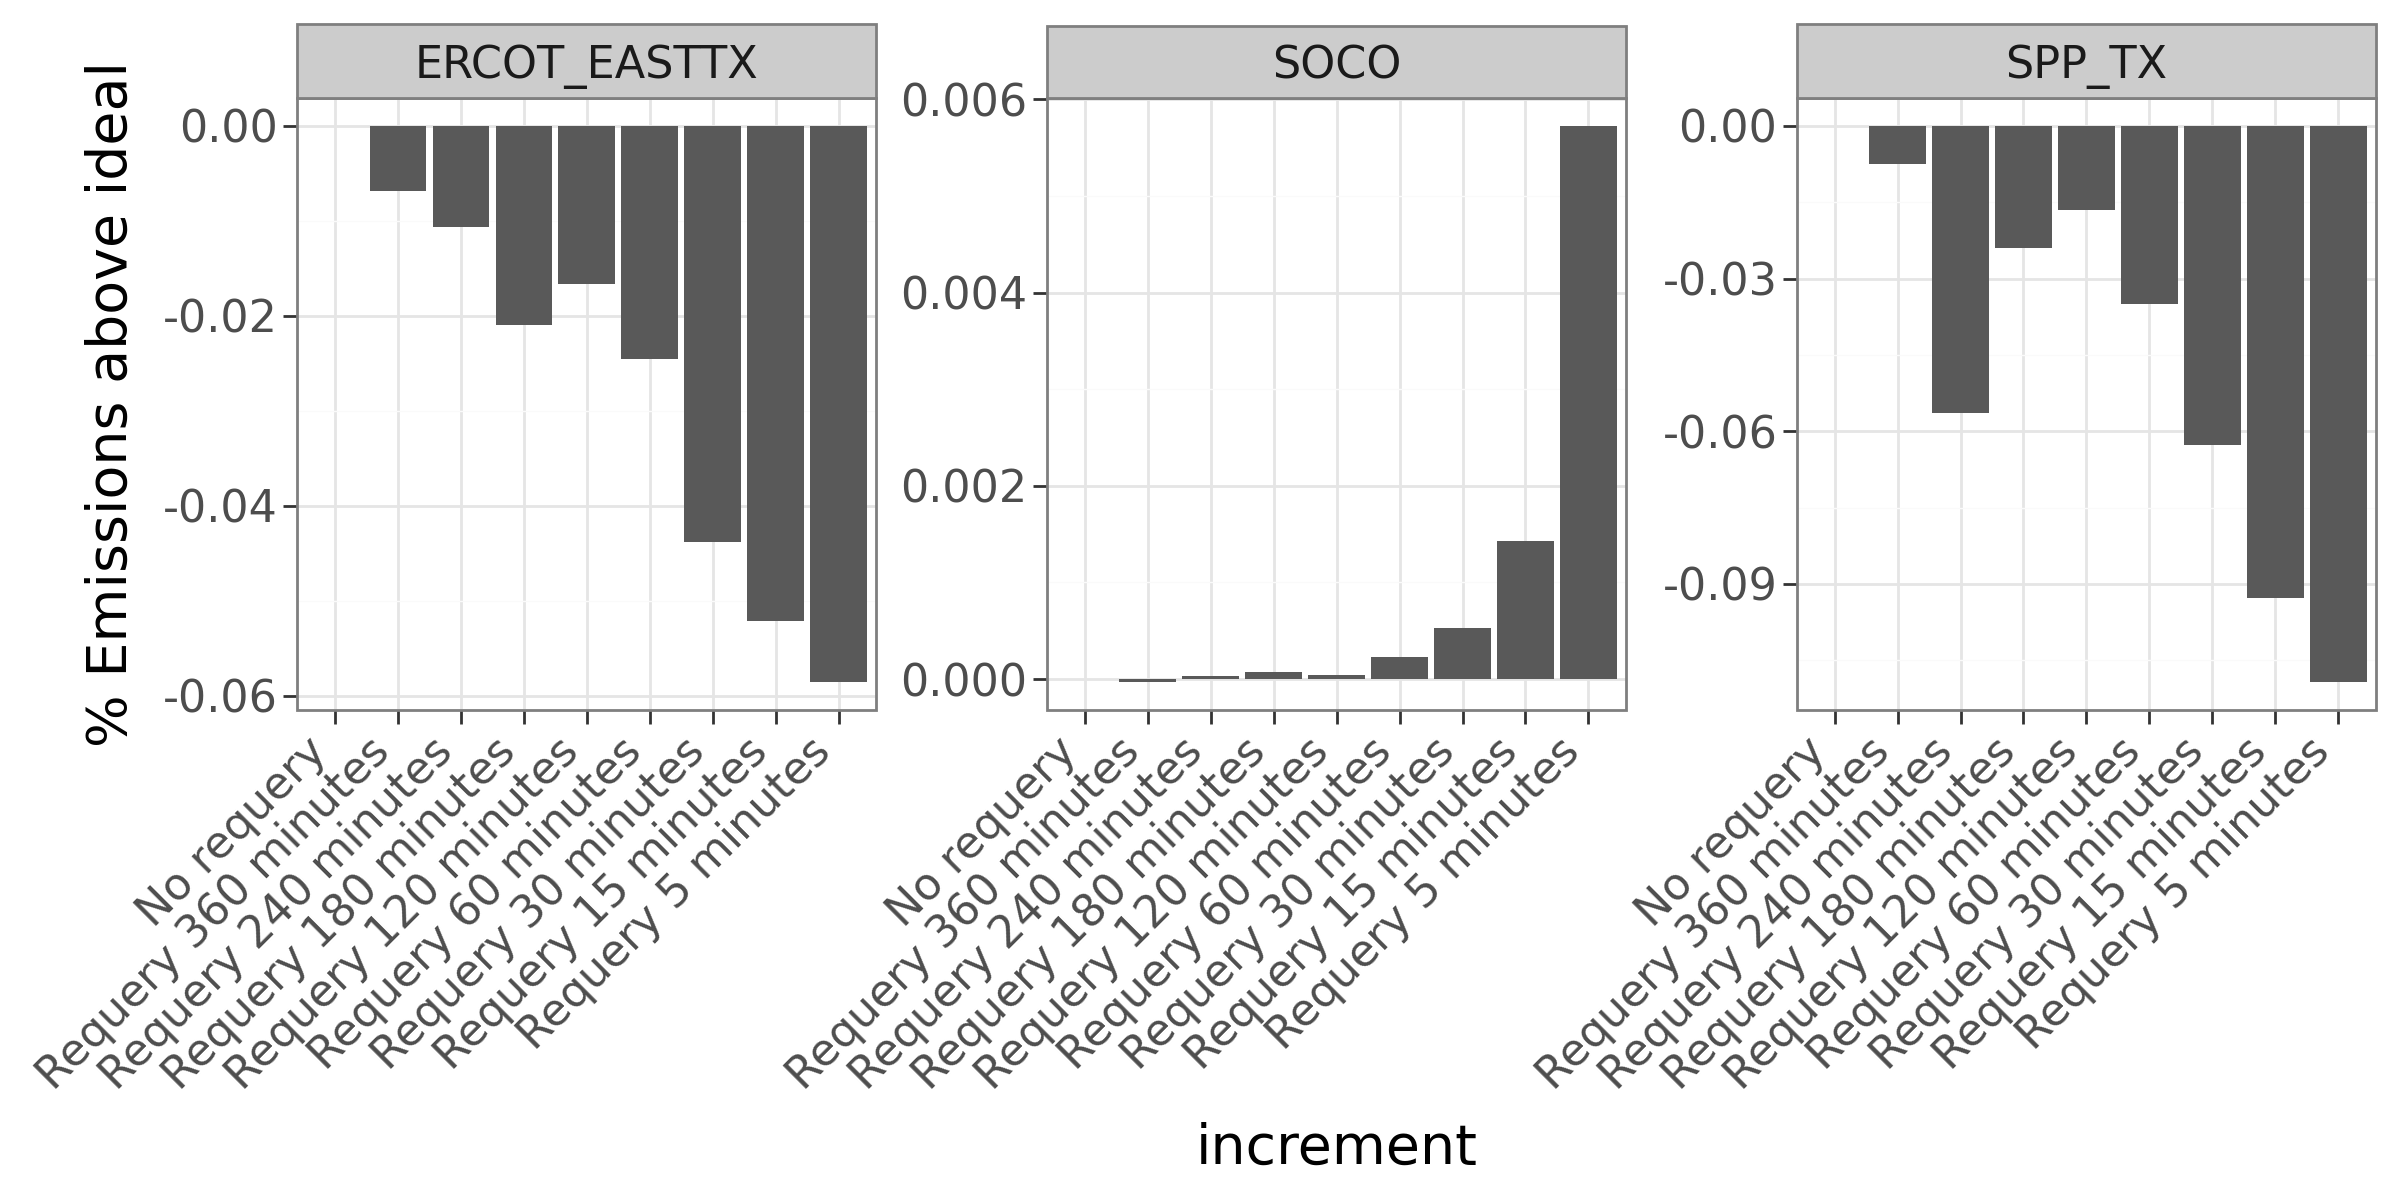

In [12]:
(ggplot(plot_dat.query("region.isin(['ERCOT_EASTTX', 'SPP_TX', 'SOCO']) & ~increment.isin(['Baseline', 'Ideal'])"), aes(x = "increment", y = "no_requery_diff")) + geom_bar(stat = "identity") + facet_wrap("~region", scales = "free_y") + theme_bw(base_size=20) +
     theme(figure_size=(12, 6),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "% Emissions above ideal"))